In [1]:
# Francisco Dominguez Mateos
# 24/06/2020
# I don't know how to convert from Flat to conv,..... in JAX jet
# 13/07/2020 I just build a custom stax layer Reshape to reshape data.
# 14/07/2020 Works!! just added .astype("float32") at random.bernoulli(rng, batch).astype("float32")
# from: https://github.com/google/jax/blob/master/examples/mnist_vae.py

In [2]:
import os
import time

import matplotlib.pyplot as plt

import numpy as onp
import jax.numpy as np
from jax import jit, grad, lax, random
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Conv, ConvTranspose, BatchNorm, Flatten, FanOut, Relu, Softplus
#from examples import datasets
import torch
from torchvision import datasets, transforms
#from: https://github.com/RobertTLange/code-and-blog/blob/master/04_jax_intro/helpers.py
#!conda install -c anaconda seaborn --yes
from helpers import plot_mnist_examples
from helpers import plot_mnist_performance

In [3]:
# Generate key which is used to generate random numbers
rng = random.PRNGKey(1)

In [4]:
# Set the PyTorch Data Loader for the training & test set
batch_size = 100

dsMnist=datasets.MNIST('./pytorch_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                       transforms.Lambda(lambda s: torch.reshape(s,(s.shape[0],28,28))),
                   ]))
train_loader = torch.utils.data.DataLoader(dsMnist, batch_size=len(dsMnist), shuffle=True)
train_iter=iter(train_loader)
train_x,train_y=next(train_iter)
print(train_x.shape)

dtMnist=datasets.MNIST('./pytorch_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                       transforms.Lambda(lambda s: torch.reshape(s,(s.shape[0],28,28))),
                   ]))
test_loader = torch.utils.data.DataLoader(dtMnist,batch_size=len(dtMnist), shuffle=True)
test_iter=iter(test_loader)
test_x,test_y=next(test_iter)
print(test_x.shape)


torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


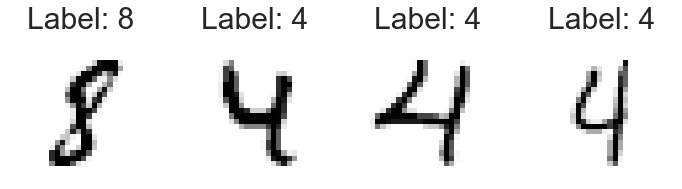

In [5]:
plot_mnist_examples(train_loader)

In [5]:
def gaussian_kl(mu, sigmasq):
  """KL divergence from a diagonal Gaussian to the standard Gaussian."""
  return -0.5 * np.sum(1. + np.log(sigmasq) - mu**2. - sigmasq)

def gaussian_sample(rng, mu, sigmasq):
  """Sample a diagonal Gaussian."""
  return mu + np.sqrt(sigmasq) * random.normal(rng, mu.shape)

def bernoulli_logpdf(logits, x):
  """Bernoulli log pdf of data x given logits."""
  return -np.sum(np.logaddexp(0., np.where(x, -1., 1.) * logits))

def elbo(rng, params, images):
  """Monte Carlo estimate of the negative evidence lower bound."""
  enc_params, dec_params = params
  mu_z, sigmasq_z = encode(enc_params, images)
  logits_x = decode(dec_params, gaussian_sample(rng, mu_z, sigmasq_z))
  return bernoulli_logpdf(logits_x, images) - gaussian_kl(mu_z, sigmasq_z)

def image_sample(rng, params, nrow, ncol):
  """Sample images from the generative model."""
  _, dec_params = params
  code_rng, img_rng = random.split(rng)
  logits = decode(dec_params, random.normal(code_rng, (nrow * ncol, 10)))
  sampled_images = random.bernoulli(img_rng, np.logaddexp(0., logits))
  return image_grid(nrow, ncol, sampled_images, (28, 28))

def image_grid(nrow, ncol, imagevecs, imshape):
  """Reshape a stack of image vectors into an image grid for plotting."""
  images = iter(imagevecs.reshape((-1,) + imshape))
  return np.vstack([np.hstack([next(images).T for _ in range(ncol)][::-1])
                    for _ in range(nrow)]).T

In [6]:
def Reshape(new_shape):
    def init_func(rng,input_shape):
        ''' there is not weight just change shape'''
        if new_shape[0]==-1:
            rnew_shape=input_shape[0:1]+new_shape[1:]
        else:
            rnew_shape=new_shape
        return (rnew_shape,())
    def apply_func(params,inputs,**kwargs):
        return np.reshape(inputs,new_shape)
    return init_func,apply_func

In [13]:
encoder_init, encode = stax.serial(
    Conv(32, (5, 5), (2, 2), padding="SAME"),
    BatchNorm(), Relu,
    Conv(32, (5, 5), (2, 2), padding="SAME"),
    BatchNorm(), Relu,
    Conv(10, (3, 3), (2, 2), padding="SAME"),
    BatchNorm(), Relu,
    Conv(10, (3, 3), (2, 2), padding="SAME"), Relu,
    Flatten,
    Dense(512), Relu,
    Dense(512), Relu,
    FanOut(2),
    stax.parallel(Dense(10), stax.serial(Dense(10), Softplus)),
)

filters=32
decoder_init, decode = stax.serial(
    Dense(512), Relu,
    Dense(512), Relu,
    Dense(14 * 14), Relu,
    Reshape((-1,14,14,1)),
    ConvTranspose(filters, (2,2), strides=(2,2), padding="SAME"),
    Conv(filters, (3, 3), (1, 1), padding="SAME"),
    BatchNorm(), Relu,
    Conv(filters, (3, 3), (1, 1), padding="SAME"),
    BatchNorm(), Relu,
    Conv(1, (3, 3), (1, 1), padding="SAME"),
)

In [16]:
step_size = 0.001
num_epochs = 100
batch_size = 32
nrow, ncol = 10, 10  # sampled image grid size

test_rng = random.PRNGKey(1)  # fixed prng key for evaluation
imfile = os.path.join(os.getenv("TMPDIR", "/tmp/"), "mnist_vae_{:03d}.png")

#train_images=, _, test_images, _ = datasets.mnist(permute_train=True)
train_images=np.array(train_x).reshape(train_x.size(0), 28,28,1)
print(train_images.shape)
test_images =np.array(test_x).reshape(test_x.size(0), 28,28,1)
print(test_images.shape)
num_complete_batches, leftover = divmod(train_images.shape[0], batch_size)
num_batches = num_complete_batches + bool(leftover)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [17]:
input_shape=(batch_size,)+train_images.shape[1:]
enc_init_rng, dec_init_rng = random.split(random.PRNGKey(2))
encoder_output_shape, init_encoder_params = encoder_init(enc_init_rng, input_shape)
print("decoder input=",encoder_output_shape[0][1])
decoder_output_shape, init_decoder_params = decoder_init(dec_init_rng, (batch_size,encoder_output_shape[0][1]))
print(encoder_output_shape,decoder_output_shape)
init_params = init_encoder_params, init_decoder_params

decoder input= 10
((32, 10), (32, 10)) (32, 28, 28, 1)


In [18]:
fake_data=random.uniform(rng,input_shape)
mu_z, sigmasq_z=encode(init_encoder_params,fake_data)
print("mu,sigmasq=",mu_z.shape,sigmasq_z.shape)

mu,sigmasq= (32, 10) (32, 10)


In [19]:
logits_x = decode(init_decoder_params, gaussian_sample(rng, mu_z, sigmasq_z))
print("logits_x=",logits_x.shape)

logits_x= (32, 28, 28, 1)


In [20]:
eloss=elbo(rng, init_params, fake_data)
print("eloss=",eloss)

eloss= -15935.539


batch= (32, 28, 28, 1)
1.0 0.0


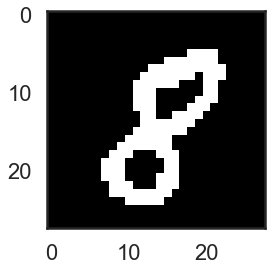

In [21]:
def binarize_batch(rng, i, images):
    i = i % num_batches
    batch = lax.dynamic_slice_in_dim(images, i * batch_size, batch_size)
    print("batch=",batch.shape)
    return random.bernoulli(rng, batch).astype("float32")

i=0
elbo_rng, data_rng = random.split(random.fold_in(rng, i))
batch = binarize_batch(data_rng, i, train_images)
img=np.reshape(batch[0],(28,28))
print(np.max(img),np.min(img))
plt.imshow(img,cmap='gray',)

In [22]:
loss = lambda params: -elbo(elbo_rng, params, batch) / batch_size
loss(init_params)

DeviceArray(664.0485, dtype=float32)

In [23]:
opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=0.9)


In [24]:
@jit
def run_epoch(rng, opt_state):
    def body_fun(i, opt_state):
        elbo_rng, data_rng = random.split(random.fold_in(rng, i))
        batch = binarize_batch(data_rng, i, train_images)
        loss = lambda params: -elbo(elbo_rng, params, batch) / batch_size
        g = grad(loss)(get_params(opt_state))
        return opt_update(i, g, opt_state)
    return lax.fori_loop(0, num_batches, body_fun, opt_state)

@jit
def evaluate(opt_state, images):
    params = get_params(opt_state)
    elbo_rng, data_rng, image_rng = random.split(test_rng, 3)
    binarized_test = random.bernoulli(data_rng, images).astype("float32")
    test_elbo = elbo(elbo_rng, params, binarized_test) / images.shape[0]
    sampled_images = image_sample(image_rng, params, nrow, ncol)
    return test_elbo, sampled_images

In [25]:
opt_state = opt_init(init_params)
for epoch in range(num_epochs):
    tic = time.time()
    opt_state = run_epoch(random.PRNGKey(epoch), opt_state)
    test_elbo, sampled_images = evaluate(opt_state, test_images[:100])
    print("{: 3d} {} ({:.3f} sec)".format(epoch, test_elbo, time.time() - tic))
    plt.imsave(imfile.format(epoch), sampled_images, cmap=plt.cm.gray)

batch= (32, 28, 28, 1)
  0 -166.62535095214844 (20.541 sec)
  1 -155.529296875 (7.547 sec)
  2 -146.87196350097656 (7.590 sec)
  3 -141.074462890625 (7.917 sec)
  4 -140.7855682373047 (8.223 sec)
  5 -137.2797393798828 (8.126 sec)
  6 -132.43275451660156 (7.889 sec)
  7 -131.06907653808594 (7.950 sec)
  8 -130.2277069091797 (8.073 sec)
  9 -128.8095703125 (7.869 sec)
 10 -128.27760314941406 (8.038 sec)
 11 -125.72262573242188 (7.983 sec)
 12 -128.99668884277344 (8.066 sec)
 13 -126.80997467041016 (8.078 sec)
 14 -126.39659118652344 (8.293 sec)
 15 -120.0643310546875 (8.414 sec)
 16 -121.6700668334961 (8.330 sec)
 17 -118.32144927978516 (8.193 sec)
 18 -119.44828796386719 (8.451 sec)
 19 -118.97901916503906 (8.228 sec)
 20 -117.93922424316406 (8.215 sec)
 21 -116.1180648803711 (8.213 sec)
 22 -115.9501953125 (8.053 sec)
 23 -115.22071075439453 (8.164 sec)
 24 -115.02058410644531 (8.298 sec)
 25 -114.42404174804688 (8.207 sec)
 26 -115.00447845458984 (8.273 sec)
 27 -115.2011489868164 (8